In [1]:
import numpy as np 
import pandas as pd
import matplotlib as plt

In [2]:
df = pd.read_csv('combine.csv', index_col = 'Month')



In [21]:
#print("Original DataFrame:")
#print(df)

# Dropping two columns
#columns_to_drop = ['.RH -0830', '.RH -1730']
#df = df.drop(columns=columns_to_drop)

#print("\nDataFrame after dropping columns:")
#print(df)


Original DataFrame:
           .MMAX  .MMIN  ..TMRF  .RH -0830  .RH -1730  dengue
Month                                                        
1/1/2010    29.0   13.7     1.5         57         32      21
1/2/2010    32.0   15.9     0.0         52         26      15
1/3/2010    38.1   21.5     0.0         51         19      24
1/4/2010    41.7   25.9     0.0         56         22      45
1/5/2010    43.8   28.8     0.0         58         18      28
...          ...    ...     ...        ...        ...     ...
4/10/2013   29.9   24.4   564.0         88         81      36
4/11/2013   29.9   23.7   886.0         90         83      51
4/12/2013   36.3   22.9     1.6         70         38      93
4/13/2013   32.8   16.3     0.0         66         36     108
4/14/2013   29.0   15.0    20.6         69         42      52

[1200 rows x 6 columns]

DataFrame after dropping columns:
           .MMAX  .MMIN  ..TMRF  dengue
Month                                  
1/1/2010    29.0   13.7     1.5   

In [3]:
from sklearn.model_selection import train_test_split


X = df.drop('dengue', axis=1)
y = df['dengue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% train, 20% test


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (960, 5)
y_train shape: (960,)
X_test shape: (240, 5)
y_test shape: (240,)


In [29]:
# prompt: differenciate y_test and y_train to ensure stationarity we know it is not stationary

# Assuming y_train and y_test are numpy arrays or pandas Series
# If they are pandas Series, convert them to numpy arrays first:
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

# Calculate the differences between consecutive elements
diff_y_train = np.diff(y_train_np)
diff_y_test = np.diff(y_test_np)

print("Differentiation of y_train:\n", diff_y_train)
print("Differentiation of y_test:\n", diff_y_test)




Differentiation of y_train:
 [  -21     8    -3    -6     0    10    53   -63     0    20   -16    40
   -44    54   389  -434     2   -11     9    18   -27     9    -8     1
     4    -4    40   -16    50   -76    17    -1   145  -161     0     1
    14    -4   -11    44   -39    40   -41    10    -6    -6    26   -26
     0   117  -107     0    15   -24     8   -10     1     2    -4    33
   -31     2    -4     3    -2    12   -12     0     5    -2    -3     0
     7     5   -13     1     5    27    43   -38   -35    26   -29     0
     3   270  -197   -22   -54   116   -92    10   -23   598  -571   -26
    -2    -2     0    -3    24   -11   -16     0    71   -72     0    17
   -18     0     0    22   -22    52   -51     0    22   -14    -8    15
    -2     2     8    16   -39     3    47   -48     3     0    11   -15
     0    22   -24     2    -2    23   -21    58   478  -536   109  -109
     1    -3    27    73  -100     7    -7   100   -96     4   154  -161
     0    11    64   -

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming X_train_scaled, y_train, X_test_scaled, and y_test are scaled datasets
# Define timesteps
timesteps = 1  # Number of previous steps to consider
features = 5
# Function to create sequences
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps + 1):
        X_seq.append(X[i:i + timesteps])
        y_seq.append(y[i + timesteps - 1])  # Target corresponds to the last timestep
    return np.array(X_seq), np.array(y_seq)

# Create sequences for training and testing
X_train_reshaped, y_train_reshaped = create_sequences(X_train_scaled, y_train, timesteps)
X_test_reshaped, y_test_reshaped = create_sequences(X_test_scaled, y_test, timesteps)

# Verify shapes
print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
print(f"y_train_reshaped shape: {y_train_reshaped.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}")
print(f"y_test_reshaped shape: {y_test_reshaped.shape}")

# Build the LSTM model
# Define the model
model = Sequential([
    # First LSTM layer
    LSTM(100, activation='relu', input_shape=(timesteps, features), return_sequences=True),
    
    # Second LSTM layer
    LSTM(70, activation='relu', return_sequences=True),
    
    # Third LSTM layer
    LSTM(40, activation='relu'),
    
    # Dense layer (fully connected hidden layer)
    Dense(20, activation='relu'),
    
    # Output layer
    Dense(1, activation='sigmoid')  
])

# Display the model summary
model.summary()
# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train_reshaped, y_train_reshaped, epochs=10, batch_size=32, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test_reshaped, y_test_reshaped, verbose=0)

# If metrics are included, 'loss' is a list; extract the first element
if isinstance(loss, list):
    loss_value = loss[0]  # Extract the loss
else:
    loss_value = loss  # Directly use the scalar loss

# Print the formatted loss value
print(f'Test Loss: {loss_value:.4f}')

# Make predictions
predictions = model.predict(X_test_reshaped)
print("Sample Predictions:", predictions[:5])

X_train_reshaped shape: (960, 1, 5)
y_train_reshaped shape: (960,)
X_test_reshaped shape: (240, 1, 5)
y_test_reshaped shape: (240,)


/var/folders/hy/c9fsrtk13m5_2f8g0rlyl2qr0000gn/T/ipykernel_14245/2333659041.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_seq.append(y[i + timesteps - 1])  # Target corresponds to the last timestep


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 1, 100)         │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 1, 70)          │        47,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 40)             │        17,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,881 (425.32 KB)

 Trainable params: 108,881 (425.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 13329.2021
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31799.2070
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29635.9023 
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14515.7725
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16668.2793
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24035.3008
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48708.5547
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45677.0000
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44039.5781
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27362.0547
Test Loss: 7353.5625
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sample Predictions: [[0.99999547]
 [0.9999827 ]
 [1.        ]
 [1.        ]
 [1.        ]]


In [19]:
# Inverse transform predictions
# Ensure predictions have the same number of features as the scaler was fitted with
predictions_extended = np.zeros((predictions.shape[0], X_train_scaled.shape[1]))
predictions_extended[:, 0] = predictions[:, 0]  # Fill only the first column with predictions

# Apply inverse transformation
predictions_inverse = scaler.inverse_transform(predictions_extended)[:, 0]  # Extract the first column

# Inverse transform the actual values (y_test)
y_test_extended = np.zeros((y_test_reshaped.shape[0], X_train_scaled.shape[1]))
y_test_extended[:, 0] = y_test_reshaped
y_test_inverse = scaler.inverse_transform(y_test_extended)[:, 0]

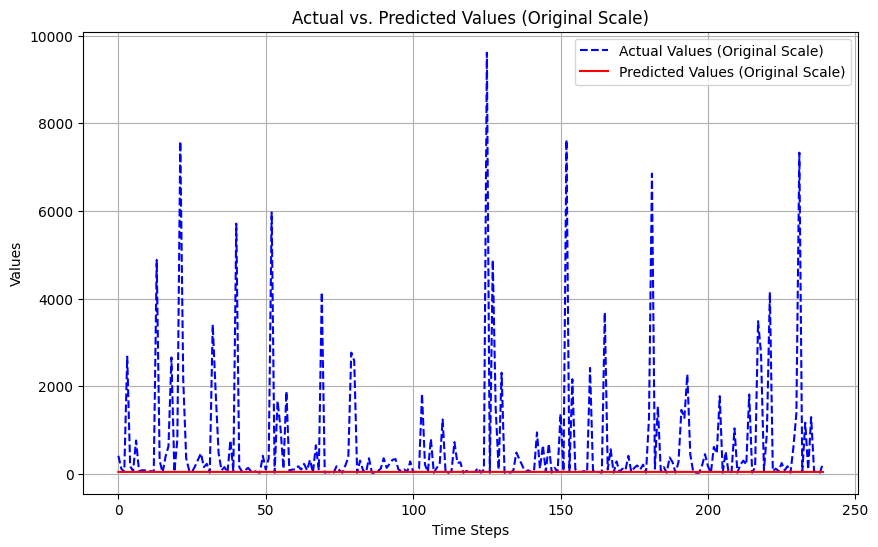

In [20]:
# Plot Actual vs. Predicted in Original Scale
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label="Actual Values (Original Scale)", color="blue", linestyle="dashed")
plt.plot(predictions_inverse, label="Predicted Values (Original Scale)", color="red")
plt.title("Actual vs. Predicted Values (Original Scale)")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming predictions_inverse and y_test_inverse are in the original scale

# Calculate Metrics
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
mse = mean_squared_error(y_test_inverse, predictions_inverse)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inverse, predictions_inverse)

# Print Metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 646.3768
Mean Squared Error (MSE): 2489622.1775
Root Mean Squared Error (RMSE): 1577.8537
R² Score: -0.1972
